# 📘 Stock Price Prediction using LSTM
## 🧠 Task 2 - CodeAlpha Data Science Internship

### This notebook predicts future stock prices using an LSTM neural network.
### Data is fetched from Yahoo Finance for stocks like AAPL, TSLA, etc.
### We preprocess the data, visualize trends, build the LSTM model, and evaluate its predictions.


### imports

In [5]:
# Stock Price Prediction using LSTM
# Task 2 - CodeAlpha Data Science Internship
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

### For LSTM model

In [9]:
# For LSTM model
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    print("TensorFlow version:", tf.__version__)
except ImportError:
    print("Please install TensorFlow: pip install tensorflow")
    print("For this demonstration, we'll show the complete code structure")

TensorFlow version: 2.19.0


### Stock selection and data download from Yahoo Finance


In [10]:
print("=== STOCK PRICE PREDICTION USING LSTM ===")
# Stock selection and data download from Yahoo Finance
STOCK_SYMBOLS = ["AAPL", "TSLA", "GOOGL", "MSFT", "AMZN"]  # Multiple options
STOCK_SYMBOL = "AAPL"  # Change this to any symbol you prefer

print(f"Available stocks: {', '.join(STOCK_SYMBOLS)}")
print(f"Selected Stock: {STOCK_SYMBOL} (Apple Inc.)")
print("You can change STOCK_SYMBOL to any of: TSLA, GOOGL, MSFT, AMZN, etc.")

# Download stock data from Yahoo Finance
print("\n📈 Downloading stock data from Yahoo Finance...")
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # 5 years of data

try:
    # Download real stock data
    stock_data = yf.download(STOCK_SYMBOL, start=start_date, end=end_date, progress=False)
    
    if stock_data.empty:
        raise ValueError("No data downloaded")
    
    print(f"✅ Data downloaded successfully from Yahoo Finance!")
    print(f"📊 Data shape: {stock_data.shape}")
    print(f"📅 Date range: {start_date.date()} to {end_date.date()}")
    
    # Save data to CSV for future use
    csv_filename = f"{STOCK_SYMBOL}_stock_data.csv"
    stock_data.to_csv(csv_filename)
    print(f"💾 Data saved to: {csv_filename}")
    
except Exception as e:
    print(f"❌ Error downloading data from Yahoo Finance: {e}")
    print("🔄 This might be due to network issues or invalid symbol")
    print("📋 Creating sample data for demonstration...")
    
    # Create realistic sample data if download fails
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    dates = dates[dates.weekday < 5]  # Remove weekends
    
    np.random.seed(42)
    # Create more realistic stock price movement
    returns = np.random.normal(0.001, 0.02, len(dates))  # Daily returns
    price_base = 150  # Starting price
    prices = [price_base]
    
    for ret in returns[1:]:
        prices.append(prices[-1] * (1 + ret))
    
    prices = np.array(prices)
    
    stock_data = pd.DataFrame({
        'Open': prices * (1 + np.random.uniform(-0.01, 0.01, len(prices))),
        'High': prices * (1 + np.abs(np.random.uniform(0, 0.02, len(prices)))),
        'Low': prices * (1 - np.abs(np.random.uniform(0, 0.02, len(prices)))),
        'Close': prices,
        'Adj Close': prices,
        'Volume': np.random.randint(50000000, 200000000, len(prices))
    }, index=dates)
    
    print("📋 Sample data created successfully!")

=== STOCK PRICE PREDICTION USING LSTM ===
Available stocks: AAPL, TSLA, GOOGL, MSFT, AMZN
Selected Stock: AAPL (Apple Inc.)
You can change STOCK_SYMBOL to any of: TSLA, GOOGL, MSFT, AMZN, etc.

📈 Downloading stock data from Yahoo Finance...
✅ Data downloaded successfully from Yahoo Finance!
📊 Data shape: (1256, 5)
📅 Date range: 2020-06-10 to 2025-06-09
💾 Data saved to: AAPL_stock_data.csv


### Display basic information about the downloaded data

In [15]:
# Drop NaNs first (important for calculations and indexing)
stock_data = stock_data.dropna()

# Get values correctly
latest_close = float(stock_data['Close'].iloc[-1])
highest_close = float(stock_data['Close'].max())
lowest_close = float(stock_data['Close'].min())
average_volume = float(stock_data['Volume'].mean())
total_days = len(stock_data)

# Print the information
print(f"\n📈 {STOCK_SYMBOL} Stock Data Overview:")
print("="*50)
print(f"Latest Close Price: ${latest_close:.2f}")
print(f"Highest Price (52-week): ${highest_close:.2f}")
print(f"Lowest Price (52-week): ${lowest_close:.2f}")
print(f"Average Daily Volume: {average_volume:,.0f}")
print(f"Total Trading Days: {total_days}")

# Daily return and volatility
stock_data['Daily_Return'] = stock_data['Close'].pct_change()
average_return = stock_data['Daily_Return'].mean() * 100
volatility = stock_data['Daily_Return'].std() * 100

print(f"\nAverage Daily Return: {average_return:.3f}%")
print(f"Daily Volatility: {volatility:.3f}%")

# Display data
print("\nStock Data Overview:")
print(stock_data.head())

print("\nStock Data Info:")
print(stock_data.info())

print("\nStock Data Statistics:")
print(stock_data.describe())



📈 AAPL Stock Data Overview:
Latest Close Price: $204.70
Highest Price (52-week): $258.40
Lowest Price (52-week): $81.63
Average Daily Volume: 80,437,651
Total Trading Days: 1255

Average Daily Return: nan%
Daily Volatility: nan%

Stock Data Overview:
Price           Close       High        Low       Open     Volume Daily_Return
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL             
Date                                                                          
2020-06-11  81.629486  85.313628  81.527423  84.888348  201662400          NaN
2020-06-12  82.334244  84.521399  81.221228  83.772909  200146000          NaN
2020-06-15  83.352493  84.006210  80.822683  80.985507  138808800          NaN
2020-06-16  85.561523  85.833709  83.772920  85.410854  165428800          NaN
2020-06-17  85.442444  86.368339  85.320935  86.307585  114406400          NaN

Stock Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2020-06-11 to 2025-06-09
Data c

### Data Visualization


=== STOCK DATA VISUALIZATION ===


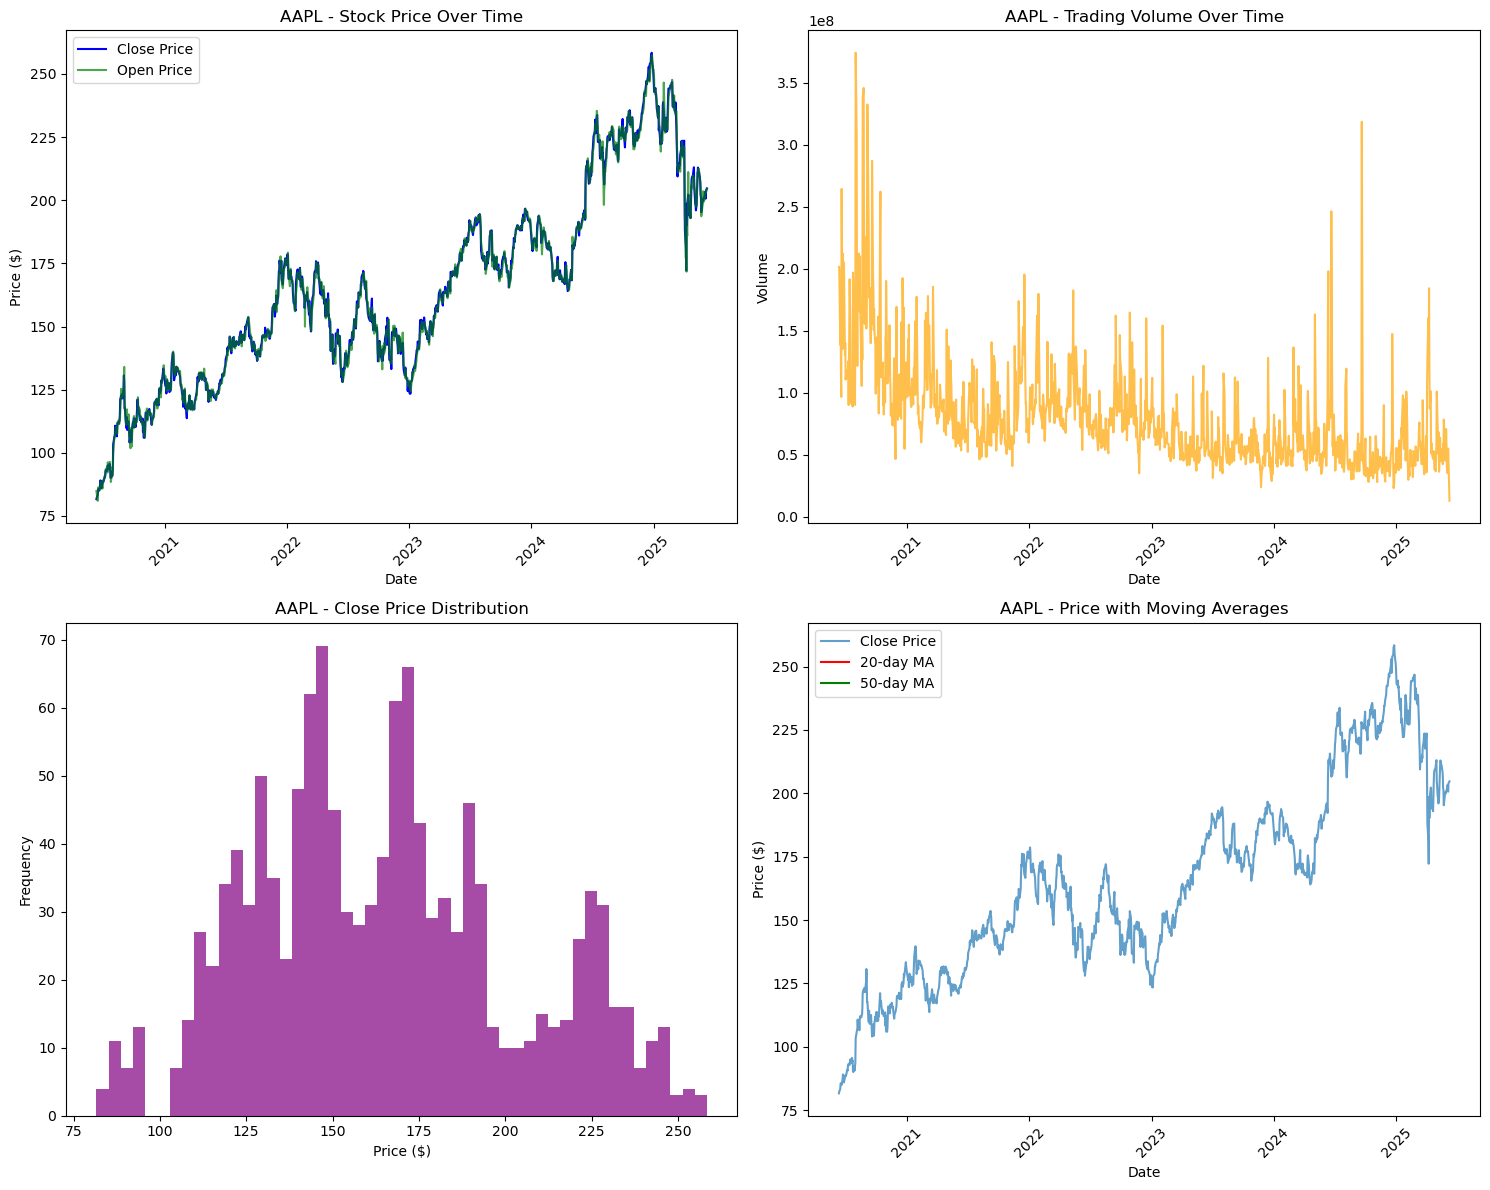


=== DATA PREPROCESSING FOR LSTM ===
Original data shape: (1255, 1)
Scaled data range: 0.0000 to 1.0000


In [17]:
print("\n=== STOCK DATA VISUALIZATION ===")

plt.figure(figsize=(15, 12))

# Stock price over time
plt.subplot(2, 2, 1)
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data.index, stock_data['Open'], label='Open Price', color='green', alpha=0.7)
plt.title(f'{STOCK_SYMBOL} - Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.xticks(rotation=45)

# Volume over time
plt.subplot(2, 2, 2)
plt.plot(stock_data.index, stock_data['Volume'], color='orange', alpha=0.7)
plt.title(f'{STOCK_SYMBOL} - Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)

# Price distribution
plt.subplot(2, 2, 3)
plt.hist(stock_data['Close'], bins=50, alpha=0.7, color='purple')
plt.title(f'{STOCK_SYMBOL} - Close Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# Moving averages
plt.subplot(2, 2, 4)
stock_data['MA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', alpha=0.7)
plt.plot(stock_data.index, stock_data['MA_20'], label='20-day MA', color='red')
plt.plot(stock_data.index, stock_data['MA_50'], label='50-day MA', color='green')
plt.title(f'{STOCK_SYMBOL} - Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Data Preprocessing for LSTM
print("\n=== DATA PREPROCESSING FOR LSTM ===")

# Use only Close price for prediction
data = stock_data['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"Original data shape: {data.shape}")
print(f"Scaled data range: {scaled_data.min():.4f} to {scaled_data.max():.4f}")

### Create sequences for LSTM

In [18]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    """Create sequences for LSTM training"""
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Set sequence length (number of days to look back)
SEQUENCE_LENGTH = 60
print(f"Sequence length: {SEQUENCE_LENGTH} days")

# Create sequences
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)
print(f"Sequences shape: X={X.shape}, y={y.shape}")

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set: X={X_test.shape}, y={y_test.shape}")

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Reshaped for LSTM: X_train={X_train.shape}, X_test={X_test.shape}")

Sequence length: 60 days
Sequences shape: X=(1195, 60), y=(1195,)
Training set: X=(956, 60), y=(956,)
Testing set: X=(239, 60), y=(239,)
Reshaped for LSTM: X_train=(956, 60, 1), X_test=(239, 60, 1)


### LSTM Model Building and Training

In [20]:
print("\n=== LSTM MODEL BUILDING ===")

try:
    # Build advanced LSTM model
    model = Sequential([
        # First LSTM layer
        LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.3),
        
        # Second LSTM layer
        LSTM(units=100, return_sequences=True),
        Dropout(0.3),
        
        # Third LSTM layer
        LSTM(units=50, return_sequences=False),
        Dropout(0.3),
        
        # Dense layers
        Dense(units=50, activation='relu'),
        Dropout(0.2),
        Dense(units=25, activation='relu'),
        Dense(units=1)
    ])

    # Compile with advanced optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='huber',  # More robust to outliers than MSE
        metrics=['mae']
    )

    print("LSTM Model Architecture:")
    model.summary()

    print("\n=== MODEL TRAINING ===")
    print("Training LSTM model... This may take a few minutes.")

    # Callbacks
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.0001,
        verbose=1
    )

    # Fit model
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=100,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1,
        shuffle=False
    )

    print("Model training completed!")

except Exception as e:
    print(f"❌ Error during model building or training: {e}")



=== LSTM MODEL BUILDING ===
LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,251 (606.45 KB)

 Trainable params: 155,251 (606.45 KB)

 Non-trainable params: 0 (0.00 B)


=== MODEL TRAINING ===
Training LSTM model... This may take a few minutes.
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0154 - mae: 0.1590 - val_loss: 0.0406 - val_mae: 0.2735 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0156 - mae: 0.1474 - val_loss: 0.0342 - val_mae: 0.2497 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0175 - mae: 0.1537 - val_loss: 0.0238 - val_mae: 0.2037 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0205 - mae: 0.1674 - val_loss: 0.0289 - val_mae: 0.2277 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0162 - mae: 0.1512 - val_loss: 0.0188 - val_mae: 0.1780 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0235 - mae: 0.1790 - val_loss: 0.0175 - val_mae: 0.1711 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0200 

In [22]:
# Enregistrer le modèle complet (architecture + poids + compilation)
model.save("lstm_stock_model.keras")
print("Model saved succesfully in file 'lstm_stock_model.keras'")


Model saved succesfully in file 'lstm_stock_model.keras'


In [23]:
#from tensorflow.keras.models import load_model

#model = load_model("lstm_stock_model.keras")
#print("Model load succesfully !")
# use of this cell for loading a saved model

### Plot training history

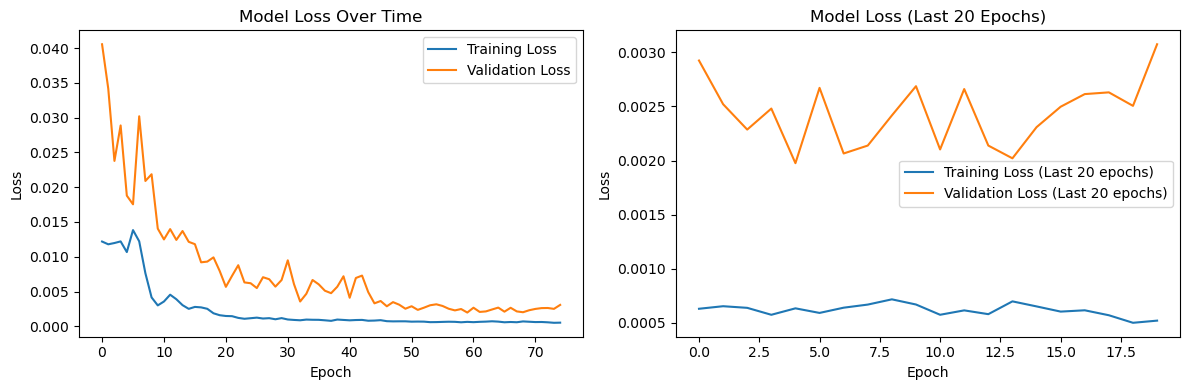

In [25]:
# Plot training history
plt.figure(figsize=(12, 4))
    
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][-20:], label='Training Loss (Last 20 epochs)')
plt.plot(history.history['val_loss'][-20:], label='Validation Loss (Last 20 epochs)')
plt.title('Model Loss (Last 20 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
plt.tight_layout()
plt.show()

### Make predictions & visualize prediction


=== MAKING PREDICTIONS ===
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Training RMSE: $4.75
Testing RMSE: $11.11
Training MAE: $3.70
Testing MAE: $9.63


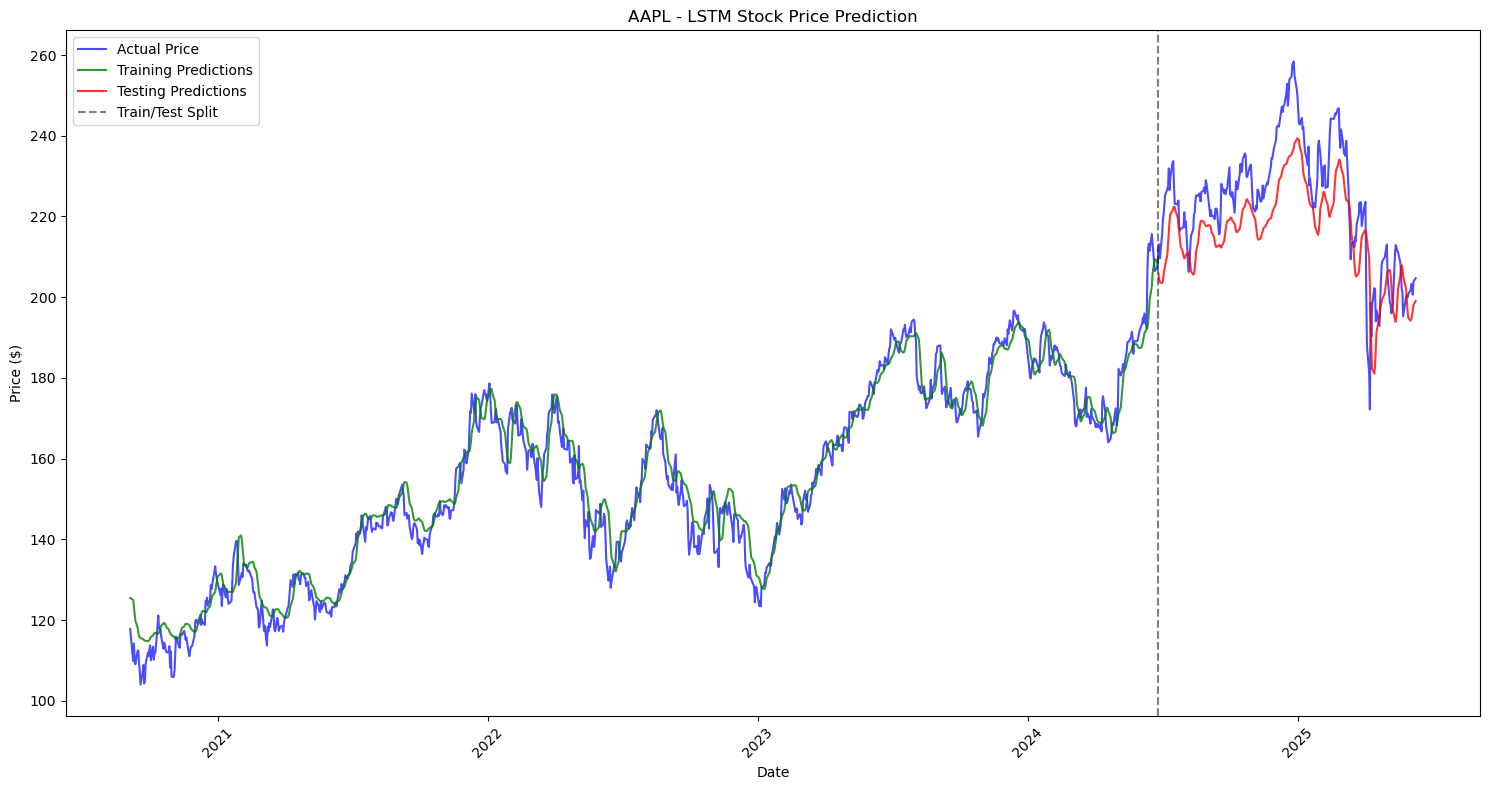

In [27]:
# Make predictions
print("\n=== MAKING PREDICTIONS ===")

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
train_mae = mean_absolute_error(y_train_actual, train_predictions)
test_mae = mean_absolute_error(y_test_actual, test_predictions)

print(f"Training RMSE: ${train_rmse:.2f}")
print(f"Testing RMSE: ${test_rmse:.2f}")
print(f"Training MAE: ${train_mae:.2f}")
print(f"Testing MAE: ${test_mae:.2f}")

# Visualize predictions
plt.figure(figsize=(15, 8))

# Create date indices for plotting
train_dates = stock_data.index[SEQUENCE_LENGTH:SEQUENCE_LENGTH+len(train_predictions)]
test_dates = stock_data.index[SEQUENCE_LENGTH+len(train_predictions):SEQUENCE_LENGTH+len(train_predictions)+len(test_predictions)]

plt.plot(stock_data.index[SEQUENCE_LENGTH:], 
         np.concatenate([y_train_actual.flatten(), y_test_actual.flatten()]), 
         label='Actual Price', color='blue', alpha=0.7)

plt.plot(train_dates, train_predictions.flatten(), 
         label='Training Predictions', color='green', alpha=0.8)

plt.plot(test_dates, test_predictions.flatten(), 
         label='Testing Predictions', color='red', alpha=0.8)

plt.axvline(x=test_dates[0], color='black', linestyle='--', alpha=0.5, label='Train/Test Split')

plt.title(f'{STOCK_SYMBOL} - LSTM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Future predictions


=== FUTURE PRICE PREDICTIONS ===


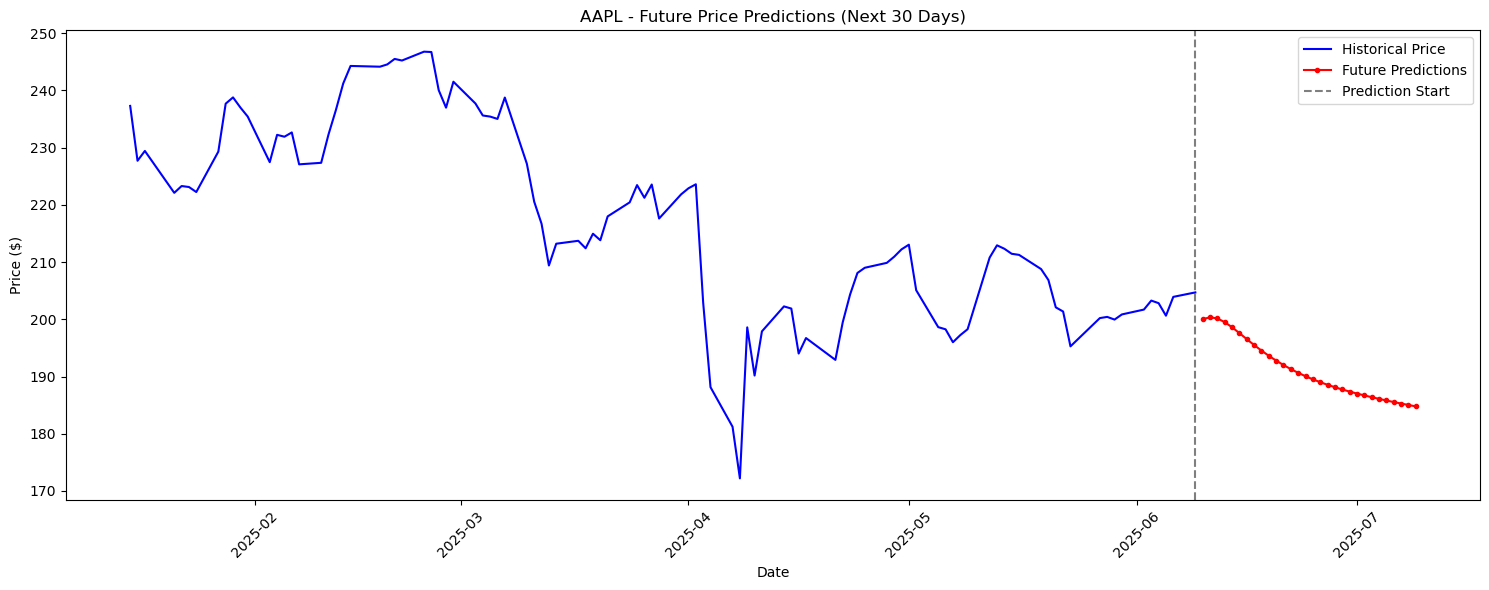

Current Price: $204.70
Predicted Price (Next Day): $200.01
Predicted Price (30 Days): $184.78
Predicted Change: -9.73%


In [32]:
# Future predictions
print("\n=== FUTURE PRICE PREDICTIONS ===")

def predict_future_prices(model, last_sequence, days=30):
    """Predict future stock prices"""
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days):
        # Predict next price
        next_price = model.predict(current_sequence.reshape(1, SEQUENCE_LENGTH, 1), verbose=0)
        predictions.append(next_price[0, 0])
        
        # Update sequence
        current_sequence = np.append(current_sequence[1:], next_price[0, 0])
    
    return np.array(predictions)

# Get last sequence from test data
last_sequence = scaled_data[-SEQUENCE_LENGTH:]

# Predict next 30 days
future_predictions_scaled = predict_future_prices(model, last_sequence.flatten(), days=30)
future_predictions = scaler.inverse_transform(future_predictions_scaled.reshape(-1, 1))

# Create future dates
future_dates = pd.date_range(start=stock_data.index[-1] + timedelta(days=1), periods=30, freq='D')

# Plot future predictions
plt.figure(figsize=(15, 6))

# Plot last 100 days
recent_data = stock_data['Close'][-100:]
plt.plot(recent_data.index, recent_data.values, label='Historical Price', color='blue')

# Plot future predictions
plt.plot(future_dates, future_predictions.flatten(), 
         label='Future Predictions', color='red', marker='o', markersize=3)

plt.axvline(x=stock_data.index[-1], color='black', linestyle='--', alpha=0.5, label='Prediction Start')

plt.title(f'{STOCK_SYMBOL} - Future Price Predictions (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Current Price: ${float(stock_data['Close'].iloc[-1]):.2f}")
print(f"Predicted Price (Next Day): ${future_predictions[0][0]:.2f}")
print(f"Predicted Price (30 Days): ${future_predictions[-1][0]:.2f}")
print(f"Predicted Change: {((future_predictions[-1][0] / float(stock_data['Close'].iloc[-1])) - 1) * 100:.2f}%")


### Model evaluation summary

In [36]:
try:
    # Model evaluation summary
    print("\n=== MODEL EVALUATION SUMMARY ===")
    print(f"Stock Symbol: {STOCK_SYMBOL}")
    print(f"Training Period: {start_date.date()} to {end_date.date()}")
    print(f"Total Data Points: {len(stock_data)}")
    print(f"Training Data Points: {len(X_train)}")
    print(f"Testing Data Points: {len(X_test)}")
    print(f"Sequence Length: {SEQUENCE_LENGTH} days")
    print(f"Model Architecture: 3 LSTM layers + 2 Dense layers")
    print(f"Training RMSE: ${train_rmse:.2f}")
    print(f"Testing RMSE: ${test_rmse:.2f}")
    print(f"Model Accuracy: {max(0, 100 - (test_rmse / np.mean(y_test_actual)) * 100):.2f}%")

except Exception as e:
    print(f"Error in model training: {e}")
    print("\nThis might be due to TensorFlow not being installed.")
    print("To run this code successfully, please install required packages:")
    print("pip install tensorflow yfinance scikit-learn matplotlib seaborn pandas numpy")



=== MODEL EVALUATION SUMMARY ===
Stock Symbol: AAPL
Training Period: 2020-06-10 to 2025-06-09
Total Data Points: 1255
Training Data Points: 956
Testing Data Points: 239
Sequence Length: 60 days
Model Architecture: 3 LSTM layers + 2 Dense layers
Training RMSE: $4.75
Testing RMSE: $11.11
Model Accuracy: 95.04%


In [37]:
### Additional Analysis

In [39]:
# === Additional Technical Analysis ===
print("\n=== ADDITIONAL TECHNICAL ANALYSIS ===")

# Define technical indicator functions first
def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD indicator"""
    exp1 = prices.ewm(span=fast).mean()
    exp2 = prices.ewm(span=slow).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=signal).mean()
    return macd, macd_signal

# Then call them
stock_data['RSI'] = calculate_rsi(stock_data['Close'])
stock_data['MACD'], stock_data['MACD_signal'] = calculate_macd(stock_data['Close'])

print(f"Current RSI: {stock_data['RSI'].iloc[-1]:.2f}")
print(f"Current MACD: {stock_data['MACD'].iloc[-1]:.4f}")

# Trading signals
latest_rsi = stock_data['RSI'].iloc[-1]
if latest_rsi > 70:
    rsi_signal = "OVERBOUGHT - Consider Selling"
elif latest_rsi < 30:
    rsi_signal = "OVERSOLD - Consider Buying"
else:
    rsi_signal = "NEUTRAL"

print(f"RSI Signal: {rsi_signal}")



=== ADDITIONAL TECHNICAL ANALYSIS ===
Current RSI: 43.00
Current MACD: -0.7815
RSI Signal: NEUTRAL
